In [55]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import log_softmax
from torch.utils.data import random_split

import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm

from jiwer import wer, cer

### Train

In [56]:
class CRNN(nn.Module):
    def __init__(self, num_classes):
        super(CRNN, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # reduce H y W
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, None))  # fuerza H = 1, W se mantiene
        )

        # Supongamos que la salida del CNN tiene tamaño (B, 128, 1, W)
        # y por tanto la entrada al RNN será (W, B, 128)
        self.rnn = nn.LSTM(input_size=128, hidden_size=256, num_layers=2, bidirectional=True)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        conv = self.cnn(x)               # (B, 128, H=1, W)
        conv = conv.squeeze(2)           # (B, 128, W)
        conv = conv.permute(2, 0, 1)     # (W, B, 128)
        rnn_out, _ = self.rnn(conv)      # (W, B, 512)
        out = self.fc(rnn_out)           # (W, B, num_classes)
        return out


In [57]:
train = False

In [58]:
# Config
CHARACTERS = "-abcdefghijklmnopqrstuvwxyz0123456789"
char_to_idx = {c: i for i, c in enumerate(CHARACTERS)}
idx_to_char = {i: c for c, i in char_to_idx.items()}

class OCRDataset(Dataset):
    def __init__(self, csv_file, img_dir):
        df = pd.read_csv(csv_file, header=None)
        self.samples = df.values.tolist()
        self.img_dir = img_dir
        self.transform = transforms.Compose([
            transforms.Grayscale(),
            transforms.Resize((32, 128)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        label = str(label)
        img = Image.open(f"{self.img_dir}/{img_path.split('/')[-1]}").convert('L')
        img = self.transform(img)
        label_idx = [char_to_idx[c] for c in label if c in char_to_idx]
        return img, torch.tensor(label_idx, dtype=torch.long), len(label_idx)


def collate_fn(batch):
    imgs, labels, label_lengths = zip(*batch)
    imgs = torch.stack(imgs)
    labels = torch.cat(labels)
    return imgs, labels, torch.tensor(label_lengths)

# Load the full dataset
full_dataset = OCRDataset("ocr_dataset_train/labels.csv", "ocr_dataset_train/img")

# Define the sizes for training and validation
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

# Split the dataset
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

In [59]:
# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = CRNN(num_classes=len(CHARACTERS)).to(device)
criterion = nn.CTCLoss(blank=0, zero_infinity=True)
optimizer = optim.Adam(model.parameters(), lr=0.001)

Using device: cuda


In [60]:
# Early stopping params
patience = 2
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_path = "ocr_model_beta.pth"

if train:
    for epoch in range(15):
        model.train()
        train_loss = 0.0

        with tqdm(train_loader, unit="batch") as tepoch:
            for imgs, labels, label_lengths in tepoch:
                imgs = imgs.to(device)
                labels = labels.to(device)

                logits = model(imgs)  # shape: (T, N, C)
                log_probs = logits.log_softmax(2)
                input_lengths = torch.full(size=(logits.size(1),), fill_value=logits.size(0), dtype=torch.long)

                loss = criterion(log_probs, labels, input_lengths, label_lengths)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                tepoch.set_description(f"Epoch {epoch+1}")
                tepoch.set_postfix(loss=loss.item())

        avg_train_loss = train_loss / len(train_loader)

        # ---- Validation ----
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for imgs, labels, label_lengths in val_loader:
                imgs = imgs.to(device)
                labels = labels.to(device)

                logits = model(imgs)
                log_probs = logits.log_softmax(2)
                input_lengths = torch.full(size=(logits.size(1),), fill_value=logits.size(0), dtype=torch.long)

                loss = criterion(log_probs, labels, input_lengths, label_lengths)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        # ---- Early Stopping Check ----
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_without_improvement = 0
            torch.save(model.state_dict(), best_model_path)
            print(f"Saved new best model to '{best_model_path}'")
        else:
            epochs_without_improvement += 1
            print(f"No improvement for {epochs_without_improvement} epoch(s)")

        if epochs_without_improvement >= patience:
            print("Early stopping triggered.")
            break

### Simple Test

In [61]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CRNN(num_classes=len(CHARACTERS)).to(device)
model.load_state_dict(torch.load("ocr_model_alpha.pth", map_location=device))
model.eval()

C:\Users\ignac\AppData\Local\Temp\ipykernel_16048\3077421666.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("ocr_model_alpha.pth", map_

CRNN(
  (cnn): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): AdaptiveAvgPool2d(output_size=(1, None))
  )
  (rnn): LSTM(128, 256, num_layers=2, bidirectional=True)
  (fc): Linear(in_features=512, out_features=37, bias=True)
)

In [62]:
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((32, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

def load_image(image_path):
    image = Image.open(image_path).convert("L")
    return transform(image).unsqueeze(0).to(device) 

In [63]:
def decode_prediction(logits, idx_to_char):
    # Logits are of shape (T, B, C) where T is sequence length, B is batch size, and C is number of classes
    pred = logits.argmax(dim=2)  # (T, B)
    pred = pred.permute(1, 0)    # (B, T) to (B, T)

    # Convert indices to characters using idx_to_char mapping
    decoded_texts = []
    for i in range(pred.size(0)):  # Iterate over batch size
        decoded_text = ''.join([idx_to_char[idx.item()] for idx in pred[i] if idx.item() != 0])  # Assuming 0 is the padding token
        decoded_texts.append(decoded_text)
    return decoded_texts


Texto detectado: ['fitness']


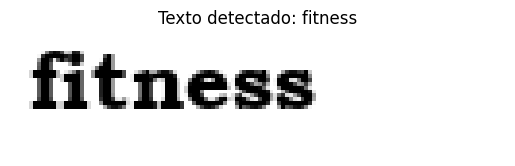

In [64]:
image_tensor = load_image("C:/Users/ignac/Escritorio/universidad/intro_imagenes/proyecto/ocr_dataset_val/img/00002.png")

with torch.no_grad():
    logits = model(image_tensor)  # (T, B, C)
    logits = logits.log_softmax(2)

predicted_texts = decode_prediction(logits, idx_to_char)
print("Texto detectado:", predicted_texts)

img_np = image_tensor.squeeze().cpu().numpy()  # -> (H, W)
# plt.imshow(img_np, cmap='gray')

plt.imshow(img_np, cmap='gray')
plt.title(f"Texto detectado: {predicted_texts[0]}")
plt.axis('off')
plt.show()

In [92]:
def load_and_binarize_image(path, threshold=100):
    # Cargar imagen y convertir a escala de grises
    image = Image.open(path).convert("L")  # Modo "L" es escala de grises

    # Convertir a numpy array
    image_np = np.array(image)

    # Invertir si el fondo es negro y texto blanco (opcional)
    image_np = 255 - image_np

    # Aplicar umbral: letras negras (0), fondo blanco (255)
    binarized = (image_np < threshold).astype(np.uint8) * 255

    # Convertir de nuevo a tensor
    image_tensor = transforms.ToTensor()(Image.fromarray(binarized))  # (1, H, W)
    return image_tensor.unsqueeze(0)  # Añadir batch -> (1, 1, H, W)

Texto detectado: ['fllllrdmidllialullmm']


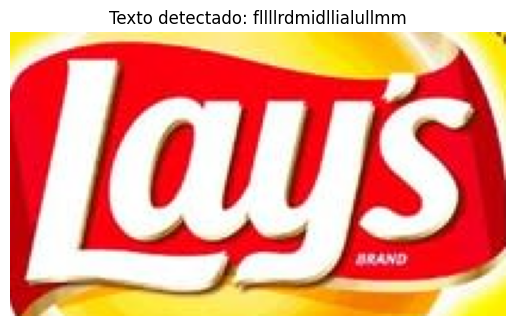

In [105]:
image_path = "C:/Users/ignac/Escritorio/universidad/intro_imagenes/proyecto/ocr_dataset_test/lays.png"
image_tensor = load_and_binarize_image(image_path).cuda()

with torch.no_grad():
    logits = model(image_tensor)
    logits = logits.log_softmax(2)

predicted_texts = decode_prediction(logits, idx_to_char)

print("Texto detectado:", predicted_texts)

# Mostrar imagen
image = Image.open(image_path)
plt.imshow(image)
plt.title(f"Texto detectado: {predicted_texts[0]}")
plt.axis('off')
plt.show()

### Test

In [ ]:
val_dataset = OCRDataset("ocr_dataset_val/labels.csv", "ocr_dataset_val/img")
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

In [ ]:
def calculate_accuracy(model, dataloader, device, idx_to_char):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels, label_lengths in tqdm(dataloader):
            imgs = imgs.to(device)
            logits = model(imgs)  # [T, B, C]
            log_probs = log_softmax(logits, dim=2)

            # Predicción y decodificación
            pred_texts = decode_prediction(log_probs, idx_to_char)

            # Reconstrucción de etiquetas reales
            labels = labels.cpu().tolist()
            lengths = label_lengths.cpu().tolist()

            gt_texts = []
            i = 0
            for l in lengths:
                gt_texts.append("".join([idx_to_char.get(c, "") for c in labels[i:i+l]]))
                i += l

            for pred, gt in zip(pred_texts, gt_texts):
                if pred == gt:
                    correct += 1
                total += 1

    return correct / total if total > 0 else 0.0

In [ ]:
# val_accuracy = calculate_accuracy(model, val_loader, device, idx_to_char)
# print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

### WER

In [ ]:
def calculate_wer(model, dataloader, device, idx_to_char):
    model.eval()
    ground_truths = []
    predictions = []

    with torch.no_grad():
        for imgs, labels, label_lengths in tqdm(dataloader, desc="Calculating WER"):
            imgs = imgs.to(device)
            logits = model(imgs)
            logits = logits.log_softmax(2)

            pred_texts = decode_prediction(logits, idx_to_char)

            label_offset = 0
            for length in label_lengths:
                true_text = ''.join([idx_to_char[idx.item()] for idx in labels[label_offset:label_offset + length]])
                ground_truths.append(true_text)
                label_offset += length

            predictions.extend(pred_texts)

    return wer(ground_truths, predictions)


In [ ]:
# val_wer = calculate_wer(model, val_loader, device, idx_to_char)
# print(f"Validation WER (Word Error Rate): {val_wer * 100:.2f}%")

### CER

In [ ]:
def calculate_cer(model, dataloader, device, idx_to_char):
    model.eval()
    ground_truths = []
    predictions = []

    with torch.no_grad():
        for imgs, labels, label_lengths in tqdm(dataloader, desc="Evaluando CER"):
            imgs = imgs.to(device)
            logits = model(imgs)
            logits = logits.log_softmax(2)

            pred_texts = decode_prediction(logits, idx_to_char)

            label_offset = 0
            for length in label_lengths:
                true_text = ''.join([idx_to_char[idx.item()] for idx in labels[label_offset:label_offset + length]])
                ground_truths.append(true_text)
                label_offset += length

            predictions.extend(pred_texts)

    return cer(ground_truths, predictions)


In [ ]:
# val_cer = calculate_cer(model, val_loader, device, idx_to_char)
# print(f"Validation CER (Character Error Rate): {val_cer * 100:.2f}%")